# Third model: Training specialists
## Early stopping, Loading pre-trained model.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
from datetime import datetime
import os
import sys
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import BatchIterator
import tensorflow as tf

/Users/alex/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Loading data

Paths to datasets.

In [18]:
FTRAIN = '~/ML/kaggle/facial-keypoints-detection/data/training.csv'
FTEST = '~/ML/kaggle/facial-keypoints-detection/data/test.csv'
FLOOKUP = '~/ML/kaggle/facial-keypoints-detection/data/IdLookupTable.csv'

In [64]:
def load(test = False, cols = None):
#     Loads data from FTEST if *test* is True, otherwise from FTRAIN.
#     Pass a list of *cols* if you're only interested in a subset of the
#     target columns.
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    #print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [65]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [66]:
num_channels = 1 # grayscale
image_size = 96

def load2d(test = False, cols = None):
    X, y = load(test = test, cols = cols)
    X = X.reshape(-1, image_size, image_size, num_channels)
    return X, y

## Parameters

In [67]:
# Predefined parameters
batch_size = 36
every_epoch_to_log = 1

data_augmentation = True
learning_rate_decay = True
momentum_increase = True
dropout = True
    
root_location = os.path.expanduser("~/ML/kaggle/facial-keypoints-detection/models/")

def model_name(spec_name):
    return "spec_" + spec_name

def model_path(spec_name):
    return root_location + "specialists/" + model_name(spec_name) + "/model.ckpt"

def train_history_path(spec_name):
    return root_location + "specialists/" + model_name(spec_name) + "/train_history"

def create_directory_for_specialist(spec_name):
    tf.gfile.MkDir(root_location)
    tf.gfile.MkDir(root_location + "specialists/")
    tf.gfile.MkDir(root_location + "specialists/" + model_name(spec_name) + "/")

## Specialists

In [68]:
SPECIALIST_SETTINGS = [
    dict(
        name = "eye_center",
        columns = (
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices = ((0, 2), (1, 3)),
        ),

    dict(
        name = "nose_tip",
        columns = (
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices = (),
        ),

    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices = ((0, 2), (1, 3)),
        ),

    dict(
        name = "mouth_bottom",
        columns = (
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices = (),
        ),

    dict(
        name = "eye_corner",
        columns = (
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices = ((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices = ((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

## Routines

This is our data augmentation routine. It randomly flips a defined portion of dataset horizontally.

In [69]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

Performs a single fully connected layer pass, e.g. returns `input * weights + bias`:

In [70]:
def fully_connected(input, size):
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

Routine for a single convolution layer pass.

In [71]:
def conv_relu(input, kernel_size, depth):
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer=tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

Routine for a pooling layer.

In [72]:
def pool(input, size):
    return tf.nn.max_pool(
        input, 
        ksize=[1, size, size, 1], 
        strides=[1, size, size, 1], 
        padding='SAME'
    )

Routine that performs entire model pass, e.g. returns model prediction for given input with current model (3 convolution layers with 2 fully connected layers):

In [73]:
def model_pass(input, keypoints):
    # Convolutions
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = 3, depth = 32) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        if dropout: pool1 = tf.nn.dropout(pool1, keep_prob = 0.9)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = 2, depth = 64)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        if dropout: pool2 = tf.nn.dropout(pool2, keep_prob = 0.8)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = 2, depth = 128)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        if dropout: pool3 = tf.nn.dropout(pool3, keep_prob = 0.7)
    
    # Fully connected
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected(pool3, size = 1000)
        if dropout: fc4 = tf.nn.dropout(fc4, keep_prob = 0.5)
    with tf.variable_scope('fc5'):
        fc5 = fully_connected(fc4, size = 1000)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc5, size = keypoints)
    return prediction

Calculates loss based on model predictions.

In [74]:
def calc_loss(predictions, labels):
    return np.mean(np.square(predictions - labels))

Calculates time since `start` and formats as a string.

In [75]:
def get_time_hhmmss(start):
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [76]:
def get_predictions_in_batches(X, y, session, predictions, tf_x_batch, tf_y_batch):
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, y_batch in batch_iterator(X, y):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch, 
                tf_y_batch : y_batch
            }
        )
        p.extend(p_batch)
    return p

In [77]:
def train_specialist(spec_setting):
    # Initialising routines:
        
    # Load data and split into datasets
    X, y = load2d(cols = spec_setting['columns'])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)    
    
    # Work out some specialist settings and prepare the file paths
    spec_name = spec_setting['name']
    create_directory_for_specialist(spec_name)
    spec_var_scope = model_name(spec_name)
    
    # Calculate some of the training hyperparameters based on the specialist and available data
    max_epochs = 5 #int(1e7 / y.shape[0])
    num_keypoints = y.shape[1]
    
    # Note training time start
    spec_start = time.time()
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, num_channels))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))

        current_epoch = tf.Variable(0)  # count the number of epochs

        # Model parameters.
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = max_epochs, decay_rate=0.03) if learning_rate_decay else 0.01
        momentum = 0.9 + (0.99 - 0.9) * (current_epoch / max_epochs) if momentum_increase else 0.9

        # Training computation.
        with tf.variable_scope(spec_var_scope):
            predictions = model_pass(tf_x_batch, num_keypoints)

        loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))
        #loss = tf.reduce_mean(tf.square(predictions - tf_y_batch)) # + l2_lambda * (tf.nn.l2_loss(weightsInToHid) + tf.nn.l2_loss(weightsHidToOut))  

        # Optimizer.
        optimizer = tf.train.MomentumOptimizer(
            learning_rate = learning_rate, 
            momentum = momentum, 
            use_nesterov = True
        ).minimize(loss)
    
    # Initiate training
    with tf.Session(graph = graph) as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver()
        train_loss_history = np.zeros(max_epochs)
        valid_loss_history = np.zeros(max_epochs)
        print("======= TRAINING: " + spec_name.replace("_", " ").upper() + " on " + str(y.shape[0]) + " EXAMPLES ========")
        for epoch in range(max_epochs):
            current_epoch = epoch
            # Train on whole randomised dataset in batches
            batch_iterator = FlipBatchIterator(batch_size = batch_size, shuffle = True) if data_augmentation else BatchIterator(batch_size = batch_size, shuffle = True)
            batch_iterator.flip_indices = spec_setting['flip_indices']
            for x_batch, y_batch in batch_iterator(x_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch
                    }
                )

            # If another significant epoch ended, we log our losses.
            if (epoch % every_epoch_to_log == 0):
                # Get training data predictions and log training loss:
                train_loss = calc_loss(
                    get_predictions_in_batches(x_train, y_train, session, predictions, tf_x_batch, tf_y_batch), 
                    y_train
                )
                train_loss_history[epoch] = train_loss

                # Get validation data predictions and log validation loss:
                valid_loss = calc_loss(
                    get_predictions_in_batches(x_valid, y_valid, session, predictions, tf_x_batch, tf_y_batch), 
                    y_valid
                )
                valid_loss_history[epoch] = valid_loss

                if (epoch % 1 == 0):
                    print("--------- EPOCH %4d/%d ---------" % (epoch, max_epochs))
                    print("     Train loss: %.8f" % (train_loss))
                    print("Validation loss: %.8f" % (valid_loss))
                    print("           Time: " + get_time_hhmmss(spec_start))

        # Evaluate on test dataset.
        test_loss = calc_loss(
            get_predictions_in_batches(x_test, y_test, session, predictions, tf_x_batch, tf_y_batch), 
            y_test
        )
        print("=========== " + spec_name.replace("_", " ").upper() + ": ============")
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
        print(" Total time: " + get_time_hhmmss(spec_start))

        # Save model weights for future use.
        save_path = saver.save(session, model_path(spec_name))
        print("Model file: " + save_path)
        np.savez(train_history_path(spec_name), train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
        print("Train history file: " + train_history_path(spec_name))        
        print("\n")

In [ ]:
start = time.time()

for spec_setting in SPECIALIST_SETTINGS:
    train_specialist(spec_setting)
    
print("====== ALL SPECIALISTS TRAINED =======")
print(" Total time: " + get_time_hhmmss(start))

======= TRAINING: EYE CENTER on 7033 EXAMPLES ========
--------- EPOCH    0/5 ---------
     Train loss: 0.00469315
Validation loss: 0.00443092
           Time: 00:01:46
--------- EPOCH    1/5 ---------
     Train loss: 0.00463840
Validation loss: 0.00439686
           Time: 00:03:32
--------- EPOCH    2/5 ---------
     Train loss: 0.00456249
Validation loss: 0.00436819
           Time: 00:05:18
--------- EPOCH    3/5 ---------
     Train loss: 0.00457918
Validation loss: 0.00437155
           Time: 00:07:04
--------- EPOCH    4/5 ---------
     Train loss: 0.00455741
Validation loss: 0.00432872
           Time: 00:08:51
=========== EYE CENTER: ============
 Test score: 3.179 (loss = 0.00438698)
 Total time: 00:08:57
Model file: /Users/alex/ML/kaggle/facial-keypoints-detection/models/specialists/spec_eye_center/model.ckpt
Train history file: /Users/alex/ML/kaggle/facial-keypoints-detection/models/specialists/spec_eye_center/train_history


======= TRAINING: NOSE TIP on 7049 EXAMPLES =

## Evaluation

In [58]:
# Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.
def plot_learning_curves(specialist = spec_name, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    model_history = np.load(train_history_path(spec_name))
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], train_linestyle, linewidth=linewidth, label=spec_name + " train")
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], valid_linestyle, linewidth=linewidth, label=spec_name + " valid")
    return epochs

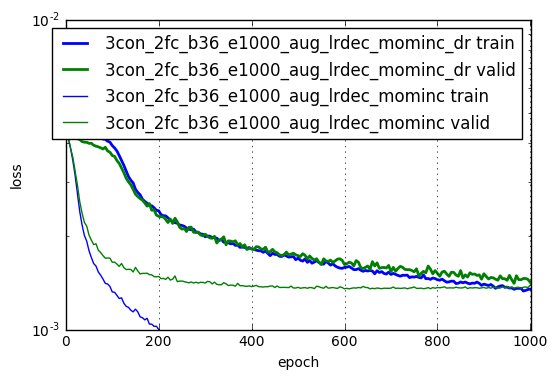

In [59]:
new_model_epochs = plot_learning_curves()
old_model_epochs = plot_learning_curves("3con_2fc_b36_e1000_aug_lrdec_mominc", linewidth = 1)

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.001, 0.01)
pyplot.xlim(0, max(new_model_epochs, old_model_epochs))
pyplot.yscale("log")
pyplot.show()

Now, let's take a look at the data and predictions. 

Load training data, restore saved model parameters and get predictions:

In [4]:
X, _ = load(test = True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope(model_variable_scope, reuse = True):
        tf_p = model_pass(tf_x)  
        
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path(SPECIALIST_SETTINGS[0].name))
    p = tf_p.eval()

NameError: name 'load' is not defined